# Basics of machine learning with text data: bag-of-words for linear regression



The `wget` command below should work on Linux or Mac OS (if wget is installed). Otherwise, just download the data and run the notebook from wherever you downloaded the data to.

In [3]:
# this should work on Mac (if wget is installed) or Unix
!wget -O - https://files.pushshift.io/twitter/US_PoliticalTweets.tar.gz | tar -xz

--2021-10-23 16:12:33--  https://files.pushshift.io/twitter/US_PoliticalTweets.tar.gz
Resolving files.pushshift.io (files.pushshift.io)... 172.67.174.211, 104.21.55.251
Connecting to files.pushshift.io (files.pushshift.io)|172.67.174.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240797053 (230M) [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>] 229.64M  11.2MB/s    in 21s     

2021-10-23 16:12:55 (10.9 MB/s) - written to stdout [240797053/240797053]



In [5]:
!du -h *.json

1.5G	tweets.json
916K	users.json


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

In [3]:
import json

with open('users.json', 'r') as infile:
    users = [json.loads(line) for line in infile.readlines()]
user_df = pd.DataFrame(users)
len(user_df)

548

In [4]:
user_df.sort_values(by='followers_count', ascending=False)[['screen_name', 'followers_count']].head(10)

,screen_name,followers_count
150,realDonaldTrump,31712585
147,POTUS,18545354
509,SenSanders,5072538
31,CoryBooker,3094413
118,marcorubio,2554822
520,SenWarren,2412087
501,SenJohnMcCain,2274034
131,NancyPelosi,1126205
90,JerryBrownGov,1119275
515,SenTedCruz,960413


In [5]:
!head -n 1 tweets.json | python -m json.tool

{
    "contributors": null,
    "coordinates": null,
    "created_at": 1217870931,
    "display_text_range": [
        0,
        74
    ],
    "entities": {
        "hashtags": [],
        "symbols": [],
        "urls": [],
        "user_mentions": []
    },
    "favorite_count": 0,
    "favorited": false,
    "geo": null,
    "id": 877418565,
    "id_str": "877418565",
    "in_reply_to_screen_name": null,
    "in_reply_to_status_id": null,
    "in_reply_to_status_id_str": null,
    "in_reply_to_user_id": null,
    "in_reply_to_user_id_str": null,
    "is_quote_status": false,
    "lang": "en",
    "place": null,
    "retweet_count": 0,
    "retweeted": false,
    "screen_name": "JohnBoozman",
    "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>",
    "text": "On a conference call about a weekend trip to Iraq to visit Arkansas troops",
    "truncated": false,
    "user_id": 5558312
}


Documentation for keys in the tweet data is provided by Twitter. [See here.](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet) It looks like we only care about the actual tweet text (`text`), the screen name of the tweeting user (`screen_name`), and the number of likes (`favorite_count`).

In [6]:
with open('tweets.json', 'r') as infile:
    tweets = []
    for line in infile:
        tweet = json.loads(line)
        tweet = {
            'screen_name': tweet['screen_name'],
            'favorite_count': tweet['favorite_count'],
            'text': tweet['text'],
        }
        tweets.append(tweet)
tweet_df = pd.DataFrame(tweets)
len(tweet_df)

1243370

In [7]:
counts = tweet_df.screen_name.value_counts()
counts.head(10)

RepDonBeyer        3258
SenatorDurbin      3252
GovMattBevin       3250
MassGovernor       3250
SenRonJohnson      3249
GrahamBlog         3249
SenTomCotton       3249
onetoughnerd       3249
RepScottPeters     3248
GovMalloyOffice    3247
Name: screen_name, dtype: int64

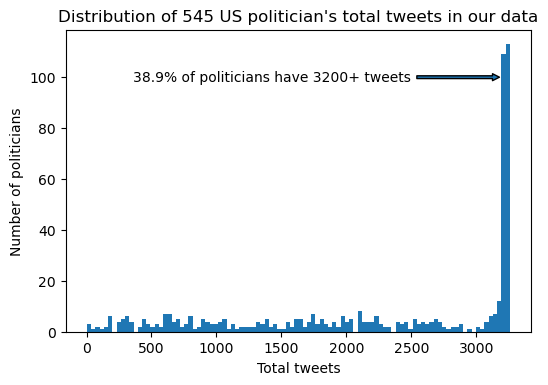

In [8]:
plt.hist(counts, bins=100)
plt.title(f"Distribution of {len(counts)} US politician's total tweets in our data")
plt.xlabel("Total tweets")
plt.ylabel("Number of politicians")
plt.annotate(f'{sum(counts >= 3200) / len(counts):.1%} of politicians have 3200+ tweets', (3200, 100), xytext=(2500, 100), arrowprops={'arrowstyle': 'simple'}, va='center', ha='right')
plt.show()

In [9]:
def simple_tokenize(tweet_text):
    tokens = tweet_text.split()
    return tokens
    
tweet_df['tokens'] = tweet_df.text.map(simple_tokenize)

In [10]:
tweet_df['token_count'] = tweet_df.tokens.map(len)
tweet_df.token_count.max()

42

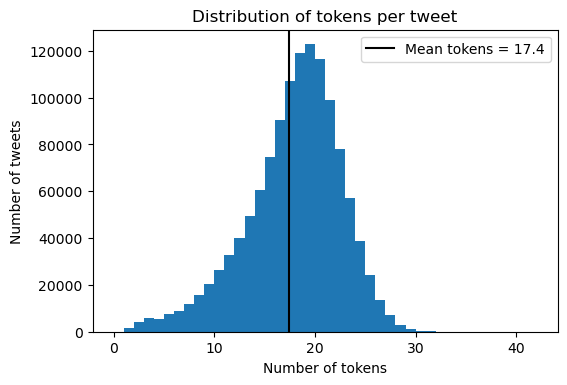

In [11]:
plt.hist(tweet_df.token_count, bins=range(0, tweet_df.token_count.max() + 1))
plt.title("Distribution of tokens per tweet")
plt.xlabel("Number of tokens")
plt.ylabel("Number of tweets")
mean_token_count = tweet_df.token_count.mean()
plt.axvline(mean_token_count, color='black', label=f'Mean tokens = {mean_token_count:.1f}')
plt.legend()
plt.show()

In [12]:
tweet_df[tweet_df.token_count == tweet_df.token_count.max()].text.iloc[0]

'.@SciCmteDems @MichaelEMann @RepBonamici @capitalweather @HouseScience @BadAstronomer @NaomiOreskes @ClimateFdbk @VariabilityBlog @RasmusBenestad @TimOsbornClim @AGW_Prof @CubaRaglanGuy @DeformedEarth @epispheric @mzelinka @hausfath @ChrisJMerchant @LovejoyShaun @PeterGleick And I want to invite anyone who wants to help defend science to fact-check future @HouseScience hearings at the hashtag #FactCheckSST 13/13'

Maybe this is making us reconsider our tokenization strategy.  

In [13]:
def better_tokenize(tweet_text):
    tokens = tweet_text.split()
    tokens = [token for token in tokens if not token.startswith('@')]
    return tokens
    
tweet_df['tokens'] = tweet_df.text.map(better_tokenize)
tweet_df['token_count'] = tweet_df.tokens.map(len)
tweet_df.token_count.max()

38

Here are the longest tweets with the new tokenization strategy.

In [14]:
# here are the longest tweets with the
for row in tweet_df.sort_values(by='token_count', ascending=False).head(5).itertuples():
    print(f"{row.screen_name}: {row.text}")

repgregwalden: .-- .. .-.. .-.. / -.-. .... .- .. .-. / -.-. --- -- -- / .- -. -.. / - . -.-. .... / ... ..- -... / --... ...-- ... / .-- --... . --.- ..
JohnKasich: More work to do &amp; we must work hard to stay on track– but we should be proud of our progress &amp; msg sent to the world: OH is the place to be. https://t.co/8Ig1abF4Ka
Jim_Jordan: All the talk of a three to four year phase out is not what we told the voters we would do - I will work to repeal it all as fast as we can
NYGovCuomo: As a New Yorker, I am a Muslim. I am a Jew. I am Black. I am gay. I am a woman seeking to control her body. We are one New York​. https://t.co/peOL9x2ltl
GOPLeader: Always great when you get to work with your friends - we have a lot to do for the public this year, but this is a great team to get it done! https://t.co/Cc8Tcdu1qc


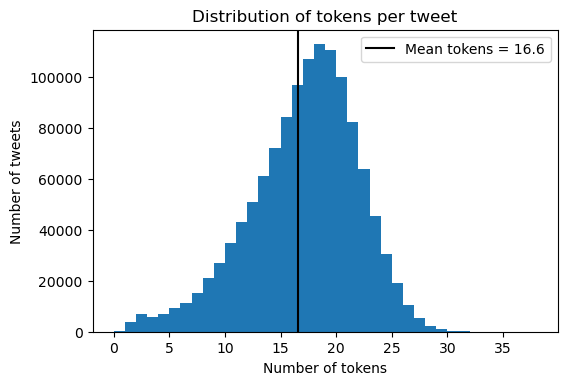

In [15]:
plt.hist(tweet_df.token_count, bins=range(0, tweet_df.token_count.max() + 1))
plt.title("Distribution of tokens per tweet")
plt.xlabel("Number of tokens")
plt.ylabel("Number of tweets")
mean_token_count = tweet_df.token_count.mean()
plt.axvline(mean_token_count, color='black', label=f'Mean tokens = {mean_token_count:.1f}')
plt.legend()
plt.show()

In [16]:
from collections import Counter

token_counter = Counter()
for tokens in tweet_df.tokens:
    token_counter.update(tokens)
token_counter.most_common(10)

[('to', 770832),
 ('the', 666572),
 ('of', 364526),
 ('in', 339118),
 ('for', 329010),
 ('RT', 266336),
 ('a', 258980),
 ('on', 249595),
 ('and', 243654),
 ('&amp;', 216680)]

### Zipf's Law

Word (or token) usage follows a predictable distribution.

If 'to' is the most common word and appears at frequency $f_{\text{max}}$, then the frequency of the second most common word is approximately $f = \frac{1}{2} f_{\text{max}}$, the frequency of the third most common word is approximately $f = \frac{1}{3} f_{\text{max}}$, etc.

In general terms, the $k$th most common word appears with frequency $f = \frac{1}{k} f_{\text{max}}$.

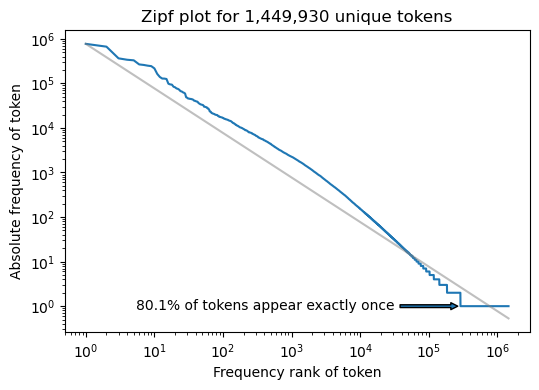

In [17]:
# plot word rank vs word count
token_counts = np.array([count for token, count in token_counter.most_common()])
plt.loglog(range(1, len(token_counts)+1), token_counts)

# compute and plot the counts if the true distribution was Zipfian
largest_count = token_counts[0]
true_zipf = [(1, largest_count)]
for i in np.geomspace(1, len(token_counts), endpoint=True, num=25):
    rank = int(i) + 1
    true_zipf.append((rank, largest_count * 1/rank))
xs, ys = zip(*true_zipf)
plt.plot(xs, ys, color='gray', linestyle='-', alpha=0.5)
plt.xlabel("Frequency rank of token")
plt.ylabel("Absolute frequency of token")
plt.title(f"Zipf plot for {len(token_counts):,} unique tokens")
# annotate the hapax legomena 
plt.annotate(f"{sum(token_counts == 1) / len(token_counts):.1%} of tokens appear exactly once",
             xy=(len(token_counts) * 0.2, 1), xytext=(10**4.5, 1), arrowprops={'arrowstyle': 'simple'}, va='center', ha='right')
plt.show()

We call tokens that appear exactly once [_hapax legomena_](https://en.wikipedia.org/wiki/Hapax_legomenon) or sometimes just _hapaxes_.

80% is higher than we would expect for more general English text: we would see that number drop if we did further normalization (e.g. so we don't count 'country.'/'country', '#Thanksgiving'/'Thanksgiving', or 'Great'/'great' as different tokens). 

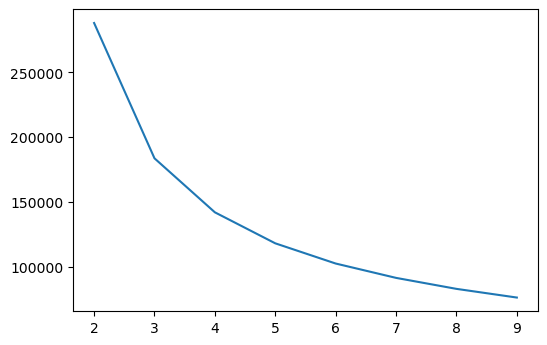

In [18]:
# how large will our vocabulary be at different absolute token frequency cut-offs?
xs = []
ys =[]
for i in range(2, 10):
    xs.append(i)
    ys.append(np.sum(token_counts >= i))
    
plt.plot(xs, ys)
plt.show()

Note: vocabulary size is an empirical question, and should be chosen based on desired purpose. If the goal is to maximize predictive model performance, than vocab size should be treated as a hyperparameter during model selection.

We'll set our vocab size to 30,000, which is a reasonable and fairly common value.

In [19]:
V = 30000
token_index_map = {}
index = 0
for token, count in token_counter.most_common(V):
    token_index_map[token] = index
    index += 1

In [20]:
# to check our work, we need to map back from indices to the actual token text
index_token_map = {index: token for token, index in token_index_map.items()}

In [21]:
token_index_map['Iraq']

2477

In [22]:
index_token_map[2477]

'Iraq'

In [23]:
# the very last word in our vocabulary
index_token_map[29999]

'“They'

Building the [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix). ("Term" just means "token".)

In [24]:
from tqdm import tqdm

In [25]:
X = np.zeros((len(tweet_df), V + 1), dtype='int8')
for row_ind, tokens in tqdm(enumerate(tweet_df.tokens), total=len(tweet_df)):
    for token in tokens:
        if token not in token_index_map:
            # this is a word not in the vocabulary!
            continue
        column_ind = token_index_map[token]
        X[row_ind, column_ind] += 1
    # the intercept column is always 1
    X[row_ind, V] = 1
X.shape

100%|██████████| 1243370/1243370 [01:56<00:00, 10642.73it/s]


(1243370, 30001)

In [26]:
row_ind = 0
print(tweet_df.iloc[row_ind].text + "\n")

for column_ind in np.argwhere(X[row_ind,:]).ravel():
    if column_ind == V:
        print(f"ind= {column_ind:>5}  n= {X[row_ind,column_ind]:.0f}  intercept")
    else:
        token = index_token_map[column_ind]
        print(f"ind= {column_ind:>5}  n= {X[row_ind,column_ind]:.0f}  token= {token}")


On a conference call about a weekend trip to Iraq to visit Arkansas troops

ind=     0  n= 2  token= to
ind=     6  n= 2  token= a
ind=    24  n= 1  token= about
ind=   128  n= 1  token= On
ind=   165  n= 1  token= visit
ind=   225  n= 1  token= call
ind=   610  n= 1  token= conference
ind=   917  n= 1  token= troops
ind=   976  n= 1  token= weekend
ind=  1107  n= 1  token= trip
ind=  1901  n= 1  token= Arkansas
ind=  2477  n= 1  token= Iraq
ind= 30000  n= 1  intercept


In [27]:
y = np.array(tweet_df.favorite_count, dtype='int32')
y.shape

(1243370,)

In [28]:
X.shape

(1243370, 30001)

In [29]:
random_inds = np.random.permutation(np.arange(len(X)))
n_train = 10000
train_inds = random_inds[:n_train]
test_inds = random_inds[n_train:]
train_inds.shape, test_inds.shape

((10000,), (1233370,))

In [32]:
X.nbytes

37302343370

In [33]:
X_train = X[train_inds]
X_train.shape

(10000, 30001)

In [ ]:
A = np.matmul(X_train.T, X_train)
A.shape

In [ ]:
A_inv = np.linalg.inv(A)

In [ ]:
y_train = y_train[train_inds]

In [ ]:
w = np.linalg.inv(A).dot(X_train.T).dot(y_train)
w.shape